<a href="https://colab.research.google.com/github/ronen-halevy/ai-notebooks/blob/main/image-classification/Building_Tensorflow_Image_Input_Pipeline_Part_3_Using_ImageGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Building Tensorflow Image Input Pipeline Part 3-Using ImageGenerator
---


## Introduction
---

The Input Data Pipeline is the preprocessing stage of the Neural Network. It operates in an **`ETL`** (**E**xtract, **T**ransform, **L**oad) pipelined process, as depicted in the figure which follows.


**`Input Data Pipeline`:**


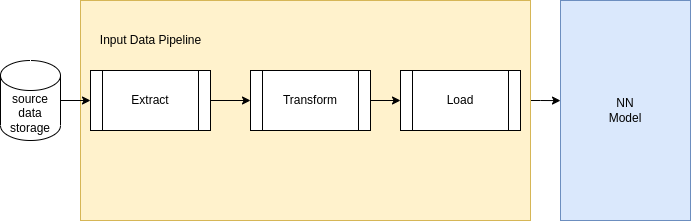

### **Input Data Pipeline Outlines**
---


The **Extract** block fetches data from input data source, which in case of Image Data Networks are most likely data files, arranges them as dataset memory objects in local memory.

The **Transform** block, naturally, transformd the data to create an efficient input data set. Most of the transforms are regarded `Performance Transforms` as they format the data to achieve better compute performance.


The **Load** block transfers the data to the Network's input layer. 



### **Commonly Used Data Transform**
---


- **Image Decoding** - decode either from jpeg or any coding format.
- **Data batching** - batches of data, be it image data or not, are required for an efficient parralelized process in general, and speciffically better exploits GPUs parralelism capabilities.
.
- **Resize** - Networks require uniform sized images only. Since source data images are mostly uniform in size, a `resize` operation is mandatory. Now, which is size to resize to? The answer is not always straight forward and definite. There are tradeoffs such as a tradeoff between details preservation vs compution and memory load. Anyway, we will set dimenssions such that after downsizing both height and width ramain integrer.



- **Normalize** (or better say scale) input data to the range [0,1]. A standardized  data range for all input data is essential for a better model Performance. 

- **Caching** of input data to avoid reloading at each epoch fitting cycle. Large datasets which do not fit in memory, should not be cached.

- **Shuffling** - which randomized the data loading sequence order.
- **Prefetch** which supports concurrent data prefetching and data processing.
- **Data Augmentation** which expands training dataset, increases the diversity of training set, by applying transformations, such as image rotation, flips, shifts.


### **About the series of posts**
---
This page is part of a series posts about **Building An Tensorflow Image Input Pipeline**.

Each post of this series presents one approach for the creation of an input image data pipeline, each uses a different set of APIs.

They differ in aspects such as level of integration (some are more integrated convinience api while others are less integrated but sometimes more flexible), and also differ in terms of efficiency and performance, (the `ImageGenerator` approach proves to be less performant)

Still, all approaches create a tensorflow dataset object which is an itegrated part of the Neural Netork Graph, along with the NN model, thus providing a smooth data integration throughout the process.

### Description of the Posts Contents

Each of the posts illustrates the creation of the input data pipeline in the context of a data classification example, using various data sources: `rock-paper-scissors`, `flowers`, and `horses or humans`


### List of the series posts:
---

The posts of this series are: 


- **Building Tensorflow Image Input Pipeline Part 1**: Using tf.data()

- [**Building Tensorflow Image Input Pipeline Part 2**: Using Keras Utils](https://colab.research.google.com/drive/1s3EdMO2uMWQMtqsPxIZOS-cvA4QqfMls#scrollTo=gpz8q177vSBj&uniqifier=2)

- **Building Tensorflow Image Input Pipeline Part 3**: Using ImageGenerator()
- **Building Tensorflow Image Input Pipeline Part 4**: Using TFDS()


Each of the posts illustrates the creation of the dataset within an image classification example. 

Let's go dive into the code!




##**About keras preprocessing ImageDataGenerator**
---
This page illustrate the building of the data pipeline with keras.preprocessing.ImageDataGenerator.

This approach provides a compact set of APIs on one hand, but proves to be less efficient in therms of computation speed comparing to other approaches. Note that it lacks performance transformations such as data caching, data prefetch.




## 1. Import Packages
---

In [138]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import random

## 2. Download the data
---
***Rock Paper Scissors***
We will use the `Rock Paper Scissors` dataset, listed in [TensorFlow Datasets catalog](https://www.tensorflow.org/datasets/catalog/overview). The dataset was produced by [Lawrance Moroney](https://laurencemoroney.com/datasets.html), million thanks for him on that.

***Downloaded Data Format***

Here we download the dataset, which is packed as a .zip file. 

In [139]:
import pathlib
dataset_name = 'rps'
dataset_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip'
dataset_file = tf.keras.utils.get_file(origin=dataset_url, fname=dataset_name+'.zip', extract=True)

dataset_file point on downloaded file:

In [140]:
print(dataset_file)

/root/.keras/datasets/rps.zip


The downloaded zip file file was extracted , due to the `extract=True` attribute.

Let's examine the zip file and the extracted directory: 

In [141]:
import os
dataset_dir = pathlib.Path(os.path.dirname(os.path.abspath(dataset_file)))
!ls $dataset_dir

rps  rps-test-set  rps_test.zip  rps.zip


#### Each dataset subdirectory to a data class: paper  rock  scissors. Here's the subdirectory list:


In [142]:
subdir_names = [f for f in os.listdir(os.path.join(dataset_dir, dataset_name))]
print(subdir_names)

['scissors', 'paper', 'rock']


The zip file downloaded so far holds the `training` data. 

The dataset's author composed another zip file which holds the `test` data. 

Next download it:

In [143]:
dataset_test_name = 'rps_test'
dataset_test_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip'
dataset_test_file = tf.keras.utils.get_file(origin=dataset_test_url, fname=dataset_test_name+'.zip', extract=True)

**Merge Train and Test Data**

The `train` and `test` datasection are pre-split 80-20. Normally, that would be fine. 

But, methodicaly, to demonstrate slicing to `train` and `validate` slices later on, we will now merge the 2 downloaded splits, and have a single big data source.

In [144]:
!cp -r /root/.keras/datasets/rps-test-set/* /root/.keras/datasets/rps

The `train` and `test` datasection are split 80-20. That is fine. but for methodical reasons, The straight forward way to do is to take them as is for training and validation respectively. Methodicaly, we will merge the 2, just to demonstrate the split capabilities of the method which follows in the next notebook cell.

Let's check how much data have we got by counting number of files in each class directory

In [145]:
from os import listdir
from os.path import isfile, join
import os

class_dir_info = {}
file_ext = 'png'

base_data_dir = os.path.join(dataset_dir, 'rps')
for subdir_name in subdir_names:
  subdir = pathlib.Path(os.path.join(base_data_dir, subdir_name))
  files_count = len([file for file in os.listdir(subdir) if file.endswith(file_ext)])
  class_dir_info.update({'dir': subdir})
  print('{}: {} files'.format(subdir_name, files_count))

print('total file count: {}'.format(len(list(pathlib.Path(base_data_dir).glob('*/*.{}'.format(file_ext))))))

scissors: 964 files
paper: 964 files
rock: 964 files
total file count: 2892


***Visualization*** - take a brief look at randomly selected images from each class

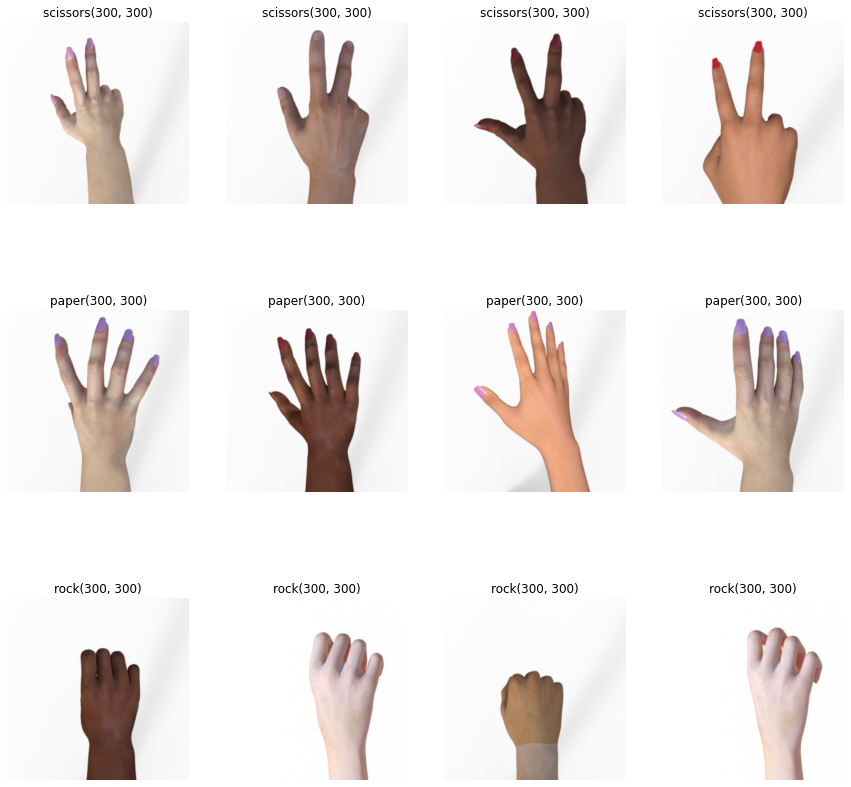

In [ ]:
plt.figure(figsize=(15, 15))
cnt = 0
for i, subdir_name in enumerate(subdir_names):
  path = pathlib.Path(os.path.join(base_data_dir, subdir_name))
  for j in range(4):
    cnt +=1
    ax = plt.subplot(3, 4, cnt)
    filename =random.choice(os.listdir(path))
    # ax = plt.subplot(1, len(subdir_names), i + 1)
    img = PIL.Image.open(os.path.join(path, filename))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(subdir_names[i]+str(img.size))

## 3. Create the Input Data Pipeline
---


**Some Value Setup**



- **batch size**: A batch size of 32 is a good starting point. There's a trade-off here, were a too small batch size might lead to a too slow processing due to lacking vectorization. A too large batch might leads to low accuracy and thus longer training time.


In [ ]:
batch_size = 32


- **image_height**, **image_width**: The are tradeoffs in setting the input dimenssions: keeping details vs process load. Anyway, since source data image is mostly none size uniform, resizing is essential. Since the NN deployed here has 5 pooling modules, which reduce size overall by 32, the size was set to a multiply of 32.


In [147]:
image_height = 224
image_width = 224

**A note on source image files storage arrangement** **bold text**

Since we use `Inferred mode`, the image source files are arranged in a per class subdirectories as depicted in the below diagram.


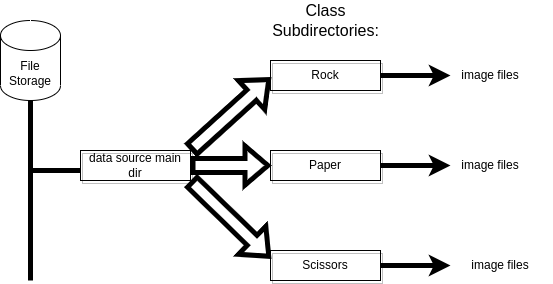

**Create the image.ImageDataGenerator**

The `ImageDataGenerator` method defines the dataset, plus, in the same time it sets up the performance parameters.


The method supports a wide set of attributes for pre-processing the data. Here below is an example with just a fraction of those supported attributes

Notes on the attributes used:

- **rotation_range**: Int. Degree range for random rotations.
  
- **shear_range**: Shear angle in counter-clockwise direction in degrees

- **zoom_range**:Range for random zoom
    
- **fill_mode**: Points outside the boundaries of the input are filled according to the given mode.
  - constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
  - 'nearest': aaaaaaaa|abcd|dddddddd
  - 'reflect': abcddcba|abcd|dcbaabcd
  - 'wrap': abcdabcd|abcd|abcdabcd

- **horizontal_flip**: Boolean. Randomly flip inputs horizontally.
- **vertical_flip**: Boolean. Randomly flip inputs vertically.
- **rescale**:  multiply the data by the value provided after applying all other transformations).

- **validation_split**:  Fraction of images reserved for validation 



In [148]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=360, #Int. Degree range for random rotations.
    shear_range=10.0, 
    zoom_range=0.1,
    fill_mode='nearest', 
    horizontal_flip=True, 
    vertical_flip=False, 
    rescale=1./255,
    validation_split=0.2
)


**Set Training data:**

**Create the Dataset**

Dataset is created by `flow_from_directory` method, based on source files resides in the specified directory.


Some Notes on Method's Attributes

- **directory**: Location of source files.

- **target_size**: The dimensions to which all images found will be resized.
- **batch_size**: Size of the batches of data (default: 32).
- **shuffle**: Whether to shuffle the data (default: `True`) If set to `False`, **sorts the data in alphanumeric order**.

- **seed**: Optional random seed for shuffling and transformations.
- **color_mode**: Whether the images will be converted to have 1 or 3 color channels.
- **subset**: Subset of data ("training" or "validation") if validation_split is set in ImageDataGenerator.

- **save_to_dir**: `None` or `str` (default: None). This allows you to optionally specify a directory to which to save the augmented pictures being generated (useful for visualizing what you are doing).
- **save_format**: one of "png", "jpeg", "bmp", "pdf", "ppm", "gif", "tif", "jpg" (only relevant if save_to_dir is set). Default: "png".

- **save_prefix**: Str. Prefix to use for filenames of saved pictures (only relevant if save_to_dir is set).

- **classes**: Optional list of classes, e.g. ['rock, 'paper', 'scissors'].  If not provided, the list of classes will be automatically inferred from the subdirectory names/structure under directory.

- **class_mode**:  Determines the type of label arrays that the generator yields. Default: "categorical". 
  - **Optional values**:

    - **"categorical"** - A 2D output, i.e. a one-hot encoding. This fits multiclass decisions. E.g. for `rock, paper, scissors`:[[1,0,0], [0,1,0],[0,0,1]]
    - **"binary"** - A 1D output, for binary classification.
    - **"sparse"** -  [0,1,2,3,4,....n] 
    - **"input"** -  for autoencoders, i.e. data is unlabeled - not in current scope.
    - **None** - No  classes are yielded by generator. useful to use with `model.predict()` 


**Returns**:

A DirectoryIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.


In the following, 2 Datasets are created: for **Training** and for **Validation**


**Create Train Dataset**

In [149]:
train_generator = image_datagen.flow_from_directory(
    directory=base_data_dir,
    target_size=(image_height, image_width), #default (256, 256)
    color_mode="rgb", #default
    batch_size=batch_size, #default 32,
    class_mode="categorical",
    classes=None, # Default None
    shuffle=True,
    seed=None, # Optional random seed for shuffling and transformations.
    subset='training' #default None
)  

Found 2316 images belonging to 3 classes.


**Create Validation Dataset**

In [150]:
validation_generator = image_datagen.flow_from_directory(
    directory=base_data_dir,
    target_size=(image_height, image_width), #default (256, 256)
    color_mode="rgb", #default
    batch_size=batch_size, #default 32,
    class_mode="categorical",
    classes=None, # Default None
    shuffle=False,
    seed=42,
    subset='validation' #default None
)  

Found 576 images belonging to 3 classes.


####**Present Train Dataset**

Present just a fraction of the dataset...

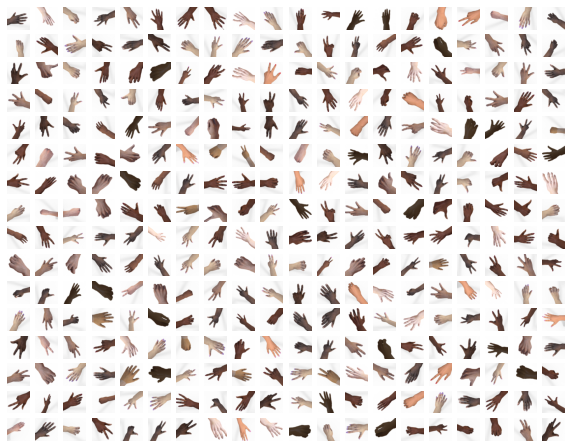

In [151]:
plt.figure(figsize=(10, 10))
batches_in_loop = 10
for j in range(batches_in_loop):
  image_batch, _ = next(iter(train_generator))
  for i in range(32):
    ax = plt.subplot(20, 20, j*32 + i + 1)
    plt.imshow(image_batch[i])
    plt.axis("off")

## 4. Set the model
---

The model consists of 7 layers:
- It begins with 5 convolution blocks, each followed by a max pooling module.

- Then, after flattening the data, convolution blocks are followed by 2 dense layers: 
 - A 128 units dense layer
 - The output layer, with 3 units according to the 3 output classes, i.e.rock, paper, scizors.


In [ ]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes,  activation = 'softmax')
])

<a name='5'></a>
## 5. Compile the Model
---

- optimizer `adam` - a commonly used stochastic adaptive optimizer.  
- loss function `SparseCategoricalCrossentropy` - commonly used for image classification with more than 2 classes
- from_logits=True - This indicate the loss function that that the output is not normalized, i.e. there is no softmax function at the output. BTW, excluding the softmax function from the model, is considered more numerically stable. The softamx is then added by the loss function module.


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## 6. Train the model
---

**Set an Early Stopping Callback:**

- Stop training when a monitored metric has stopped improving.

- Wait before stopping according `patience` value.

- Restore best waits, after stopping



In [ ]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=0, 
                                patience=10, 
                                verbose=1, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=True)

Now do the fit - 30 epochs, with early_stop_cb.

In [ ]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop_cb],
)

## 7. Display model summary
---

In [ ]:
model.summary()

## 8. Visualize training results
---

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 10. Inference
---

The train model will now be tested with test data.

1. Inference with test dataset downloaded from `Kaggle`. 

2. Inference with interactively uploaded test dataset

### Inference with test dataset from `Kaggle`

**In this section, the following stages are executed:**
  - **Upload `Kaggle` Auth token** - required before the dataset download from `Kaggle` is authorized.
  - **Download the test dataset from `Kaggle`**
  - **Run `model.predict` over the test dataset**
  - **Run `model.evaluate` over the test dataset**

**Uppload Kaggle Auth Token**

The kaggle auth token is stored in a file called `kaggle.json`.


If you have already a `kaggle.json` file, the code in the notebook cell which follows will upload it (click on `Choose Files`).
 
If you don't, you can generate one - click [here](https://ronen-halevy.github.io/2021/11/15/kaggle-api-settings.html) for a post on setting Kaggle API.



In [ ]:
from google.colab import files

uploaded = files.upload()
  
# Move kaggle.json into ~/.kaggle:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json



**Download the test dataset from Kaggle and unzip it**

In [ ]:
!kaggle datasets download -d ronenhalevy/rps-test
!unzip rps-test.zip

rps-test.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  rps-test.zip
  inflating: rps_test/paper/papaer9.jpg  
  inflating: rps_test/paper/papar10.jpg  
  inflating: rps_test/paper/paper-2.jpg  
  inflating: rps_test/paper/paper3.jpg  
  inflating: rps_test/paper/paper6.jpg  
  inflating: rps_test/rock/rock.jpg  
  inflating: rps_test/rock/rock3.jpg  
  inflating: rps_test/rock/rock4.jpg  
  inflating: rps_test/rock/rock5.jpg  
  inflating: rps_test/rock/rock7.jpg  
  inflating: rps_test/rock/rock8.jpg  
  inflating: rps_test/rock/sn-rock.jpg  
  inflating: rps_test/scissors/scisors.jpg  
  inflating: rps_test/scissors/scissors3.jpg  
  inflating: rps_test/scissors/scissors4.jpg  
  inflating: rps_test/scissors/scissors5.jpg  
  inflating: rps_test/scissors/scissors6.jpg  
  inflating: rps_test/scissors/scissors7.jpg  
  inflating: rps_test/scissors/scissors8.jpg  
  inflating: rps_test/scissors/sn-scissors.jpg  


**Run `model.predict` over the test dataset**

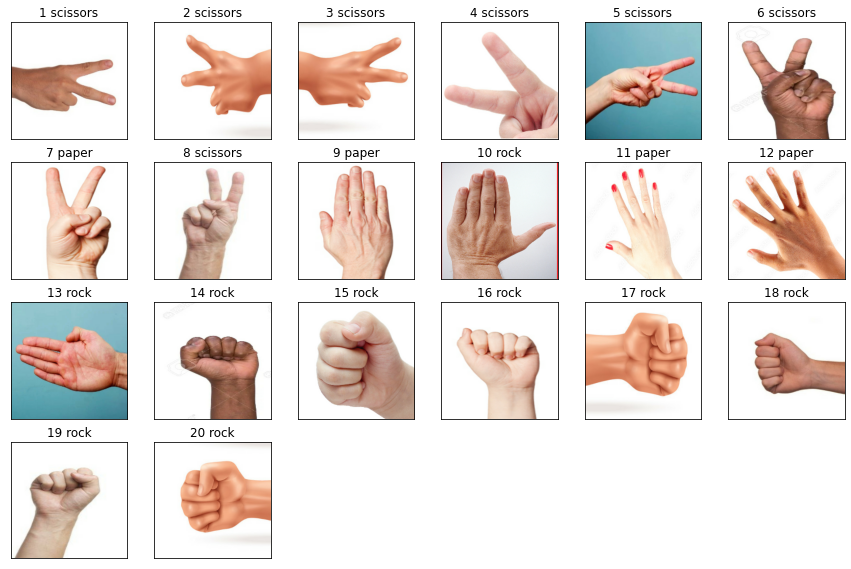

In [ ]:
def plot_bounding_box(fig, ax, color):
  fig.canvas.draw()
  bbox = ax.get_tightbbox(fig.canvas.renderer)
  x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
  xpad = 0.05 * width
  ypad = 0.05 * height
  fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor=color, linewidth=3, fill=False))

def do_prediction(image_folder):
    class_name=[]
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    cnt = 0
    for jdx, dir1 in enumerate(os.listdir(image_folder)):
        for idx, file in enumerate(os.listdir(os.path.join(image_folder, dir1))):
            cnt += 1
            ax = fig.add_subplot(6, 6, cnt)
            image= os.path.join(image_folder,dir1, file)
            image = tf.io.read_file(image)
            image = tf.io.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, (image_height,image_width))
            image = tf.cast(image / 255., tf.float32)
            ax.imshow(image)
            image = tf.expand_dims(image, axis=0)
            result=model.predict(tf.stack(image, axis=0))
         
            ax.set_xticks([])
            ax.set_yticks([])

            error = False if class_names[np.argmax(result)] == dir1 else True
            ax.set_title("{} {}"
              .format(cnt, class_names[np.argmax(result)]), color=color
            )   
            plot_bounding_box(fig, ax, color)

    return
img_folder='rps_test'
do_prediction(img_folder)


**Examine prediction results**

Obviously, results with validation dataset were much better. 

There are a number of miss-classification results. A larger train dataset would probably bring better preformance, e.g. note that all papers in training dataset have gaps between fingers, and scissors images are different than those of the test dataset.



**Find Accuracy and Loss**
 
Run `model.evaluate` over the test dataset. It calculates loss and accuracy for this data.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  'rps_test',
  seed=123,
  image_size=(image_height, image_width),
  batch_size=3)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

results = model.evaluate(test_ds)

print(f'Test {model.metrics_names[0]}: {results[0]} / Test model.metrics_names[1]: {results[1]}')



Found 20 files belonging to 3 classes.
7/7 [==============================] - 0s 5ms/step - loss: 0.7307 - accuracy: 0.8500
Test loss: 0.7307165861129761 / Test model.metrics_names[1]: 0.8500000238418579


### **Inference with interactively uploaded test dataset**


---


In next notebook cell, you can interactively upload test files(s) and execute inference

Saving papaer9.jpg to papaer9 (3).jpg
Saving papar10.jpg to papar10.jpg


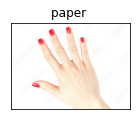

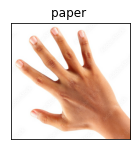

In [ ]:
  uploaded = files.upload()
  cnt = 0
  for path in uploaded.keys():
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    image = tf.image.resize(img, [image_height, image_width])
    image = tf.expand_dims(image, axis=0)
    image = image / 255.0
    cnt = cnt + 1
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)

    results = model.predict(image)
    result = results[0]
    ax = fig.add_subplot(6, 6, cnt)
    ax.set_title("{} ".format(class_names[np.argmax(result)]))  
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])